# Import relevant modules

In [27]:
import xml.etree.ElementTree as ET
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

## Process active motion xml

This is the initialization step where we define the starting folder and ask the user to confirm or change it.

In [28]:
# Define the starting folder path
start_path = r'D:\\Particle tracking'

root = tk.Tk()
root.withdraw() # Hide the main window

# Bring the dialog to the front
root.lift()
root.attributes('-topmost', True)

try:
    # Allow the user to select an XML file starting from the specified start path
    xml_file_path = filedialog.askopenfilename(initialdir=start_path, filetypes=[("XML files", "*.xml")])
    
    if xml_file_path:
        print(f"Selected XML file path: {xml_file_path}")
    else:
        print("No XML file selected.")
        
except FileNotFoundError:
    print("File selection canceled by the user.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Selected XML file path: E:/Particle tracking/Summer Semester Jun-Aug 2024/14JUL24/Cycle study/0 cycles/150 mVpp/Compilation/xml/240000 cycles.xml


### Obtain active motion trajectories

note here if you have issues with kernel: https://stackoverflow.com/questions/53004311/how-to-add-conda-environment-to-jupyter-lab

In [65]:
def extract_trajectories_from_xml_to_df(xml_file_path):
    # Parse the XML file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Initialize a list to store extracted data
    extracted_data = []

    # Extract the ultrasound_burst_frame value
    ultrasound_burst_frame = int(root.find('UltrasoundBurstFrame').text)

    # Iterate over each <Particle> element and extract x, y, frame, particle, size, displacement, total_distance_traveled, and speed values
    for particle in root.findall('Particles/Particle'):
        x = float(particle.find('x').text)
        y = float(particle.find('y').text)
        frame = int(float(particle.find('frame').text))  # Convert frame to float and then to int
        particle_id = int(particle.find('particle').text)  # Assuming 'particle' is the identifier
        size = float(particle.find('size').text)  # Extract size here
        displacement = float(particle.find('displacement').text)  # Extract displacement

        # Append the extracted values to the list as a dictionary
        extracted_data.append({
            'particle': particle_id,
            'frame': frame,
            'x': x,
            'y': y,
            'size': size,
            'displacement': displacement,
            'ultrasound_burst_frame': ultrasound_burst_frame
        })

    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(extracted_data)

    # Sort by frame and then by particle
    df.sort_values(by=['frame', 'particle'], inplace=True)

    # Set the frame column as the DataFrame's index
    df.set_index('frame', inplace=True)

    # Reset index to make frame a column as well
    df.reset_index(inplace=True)

    return df

# Example usage
active_traj_filt = extract_trajectories_from_xml_to_df(xml_file_path)

# If you need to scale x, y, or size by a certain factor, you can do so here as shown for x and y
active_traj_filt['x'] = active_traj_filt['x'] * 1.3
active_traj_filt['y'] = active_traj_filt['y'] * 1.3

### Plot total distance and speed vs time plots

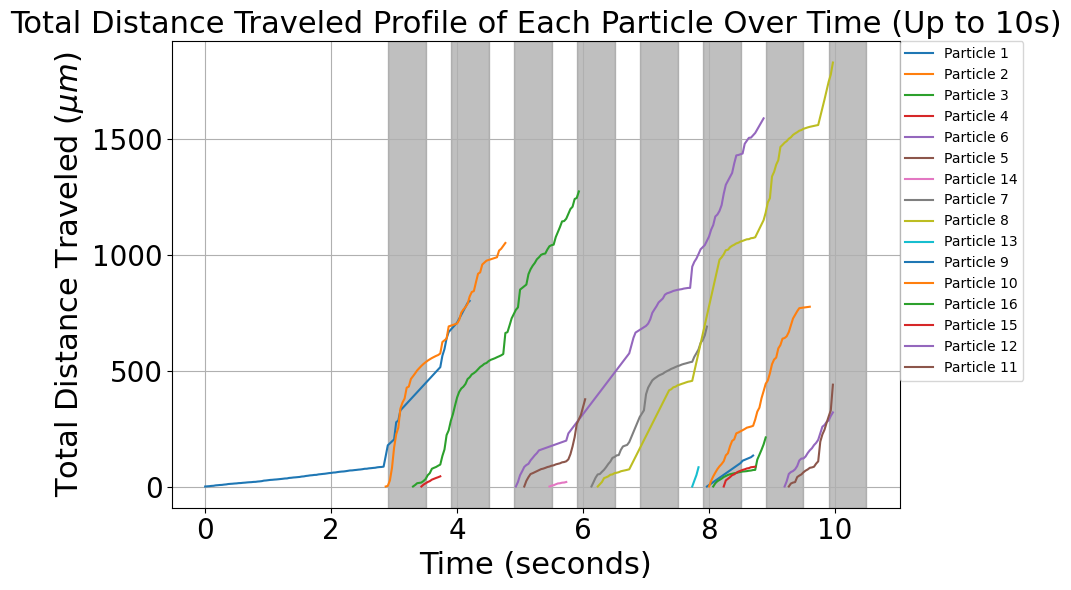

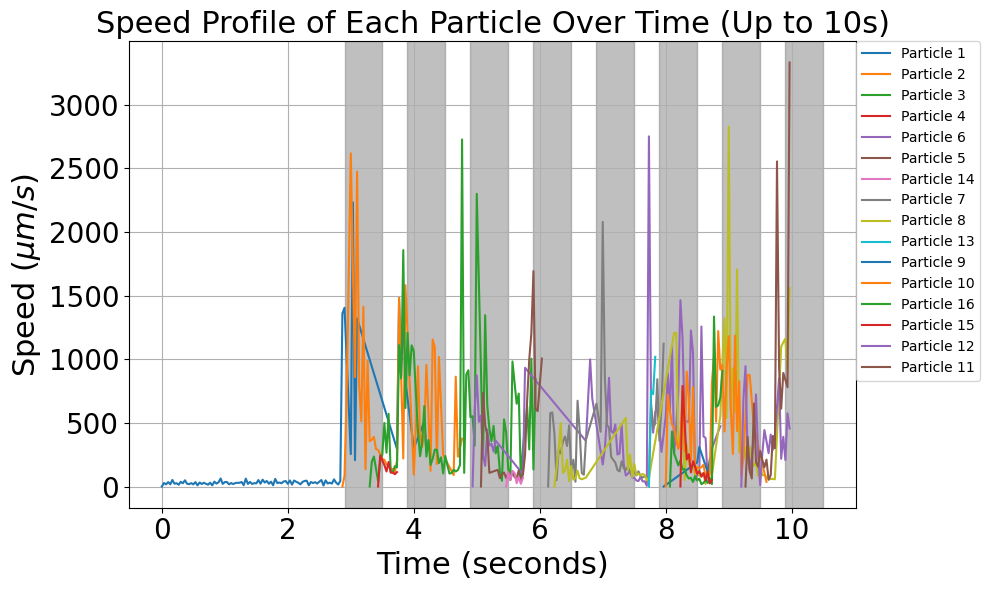

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming active_traj_filt is already defined and calculated as before
# Define the necessary parameters
frame_rate = 30  # Example frame rate
fps = frame_rate
max_time = 10  # Truncate data up to 10 seconds

# Calculate the time for each frame
active_traj_filt['time'] = active_traj_filt['frame'] / fps
active_traj_filt = active_traj_filt[active_traj_filt['time'] <= max_time]

# Calculate the displacement and total distance traveled
active_traj_filt['dx'] = active_traj_filt.groupby('particle')['x'].diff().fillna(0)
active_traj_filt['dy'] = active_traj_filt.groupby('particle')['y'].diff().fillna(0)
active_traj_filt['displacement'] = np.sqrt(active_traj_filt['dx']**2 + active_traj_filt['dy']**2)

# Calculate the total distance traveled for each particle
active_traj_filt['total_distance_traveled'] = active_traj_filt.groupby('particle')['displacement'].cumsum()

# Calculate the time interval for each frame
active_traj_filt['time_interval'] = active_traj_filt.groupby('particle')['time'].diff().fillna(1/fps)

# Calculate the speed for each particle
active_traj_filt['speed'] = active_traj_filt['displacement'] / active_traj_filt['time_interval']

# Replace inf values with 0 in speed using assign method to avoid the warning
active_traj_filt = active_traj_filt.assign(speed=active_traj_filt['speed'].replace([np.inf, -np.inf], 0))

# Plotting the total distance traveled with ultrasound burst lines for the truncated data
fig1, ax1 = plt.subplots(figsize=(10, 6))
for particle in active_traj_filt['particle'].unique():
    particle_data = active_traj_filt[active_traj_filt['particle'] == particle]
    ax1.plot(particle_data['time'], particle_data['total_distance_traveled'], label=f'Particle {particle}')

# Add vertical shaded areas for ultrasound bursts
ultrasound_burst_frame_increment = 10  # Replace with the value to add to the existing UltrasoundBurstFrame value
hifu_burst_frame_average = active_traj_filt['ultrasound_burst_frame'].mean() + ultrasound_burst_frame_increment
hifu_burst_start = (hifu_burst_frame_average / frame_rate)

for burst_time in np.arange(hifu_burst_start, max_time + 1, 1):
    ax1.axvspan(burst_time - 0.3, burst_time + 0.3, color='gray', alpha=0.5)

# Set labels, title, and adjust font sizes
plot_font_size = 22
tick_font_size = 20
ax1.set_xlabel('Time (seconds)', fontsize=plot_font_size)
ax1.set_ylabel(r'Total Distance Traveled ($\mu m$)', fontsize=plot_font_size)
ax1.set_title(f'Total Distance Traveled Profile of Each Particle Over Time (Up to {max_time}s)', fontsize=plot_font_size)
ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax1.grid(True)
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

# Close the figure to free up memory
plt.close(fig1)

# Plotting the instantaneous velocities with ultrasound burst lines for the truncated data
fig2, ax2 = plt.subplots(figsize=(10, 6))
for particle in active_traj_filt['particle'].unique():
    particle_data = active_traj_filt[active_traj_filt['particle'] == particle]
    ax2.plot(particle_data['time'], particle_data['speed'], label=f'Particle {particle}')

# Add vertical shaded areas for ultrasound bursts
for burst_time in np.arange(hifu_burst_start, max_time + 1, 1):
    ax2.axvspan(burst_time - 0.3, burst_time + 0.3, color='gray', alpha=0.5)

# Set labels, title, and adjust font sizes
ax2.set_xlabel('Time (seconds)', fontsize=plot_font_size)
ax2.set_ylabel('Speed ($\mu m/s$)', fontsize=plot_font_size)
ax2.set_title(f'Speed Profile of Each Particle Over Time (Up to {max_time}s)', fontsize=plot_font_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax2.grid(True)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

# Close the figure to free up memory
plt.close(fig2)


In [67]:
# Remove trajectories from active_traj_filt

def delete_particles_rows(df, particle_numbers):
    """
    Deletes rows from the DataFrame based on a list of particle numbers.
    
    Parameters:
    - df: The DataFrame from which to delete rows.
    - particle_numbers: A list or array of particle numbers whose rows should be deleted.
    """
    # Find indices of rows where the 'particle' column matches any of the specified particle numbers
    indices_to_delete = df[df['particle'].isin(particle_numbers)].index
    
    # Drop these rows from the DataFrame
    df.drop(indices_to_delete, inplace=True)

# Example usage:
particle_numbers_to_delete = []  # Specify the particle numbers you want to delete as a list

# Assuming active_traj_filt is your DataFrame
delete_particles_rows(active_traj_filt, particle_numbers_to_delete)

#Re-plot
#plot_trajectories(active_traj_filt, microns_per_pixel, line_width)

#plot_trajectories(active_traj_filt, microns_per_pixel, line_width, axis_label_size, tick_label_size, save_path)

### Calculate relevant metrics

In [68]:
frame_rate = 30

def confinement_ratio_continuous(df):
    # Calculate the net displacement from the first frame to each subsequent frame
    net_displacement = np.sqrt((df['x'] - df['x'].iloc[0])**2 + (df['y'] - df['y'].iloc[0])**2)
    # Total distance traveled up to each frame
    cumulative_distance = df['total_distance_traveled']
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        confinement_ratio = net_displacement / cumulative_distance
    return confinement_ratio

def directionality_continuous(df):
    # Calculate net displacement in the x direction from the first frame to the last frame
    net_displacement_x = abs(df['x'].iloc[-1] - df['x'].iloc[0])
    # Total distance traveled up to each frame
    cumulative_distance = df['total_distance_traveled']
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        directionality = net_displacement_x / cumulative_distance
    return directionality

def calculate_instantaneous_speed(df, frame_rate):
    """
    Calculate the instantaneous speed at each frame interval.

    Args:
        df (pandas.DataFrame): DataFrame containing 'x' and 'y' columns.
        frame_rate (float): Frame rate of the data.

    Returns:
        numpy.ndarray: Array of instantaneous speeds.
    """
    # Calculate the differences in x and y
    dx = np.diff(df['x'])
    dy = np.diff(df['y'])

    # Calculate the distance traveled between frames
    distances = np.sqrt(dx**2 + dy**2)

    # Calculate the time between frames
    dt = 1 / frame_rate  # Constant if frame rate is consistent

    # Calculate the instantaneous speeds
    instantaneous_speeds = distances / dt

    return instantaneous_speeds


def linearity_forward_progression(df, frame_rate):
    """
    Calculate the linearity of forward progression.

    Args:
        df (pandas.DataFrame): DataFrame containing 'x' and 'y' columns.
        frame_rate (float): Frame rate of the data.

    Returns:
        float: Linearity of forward progression.
    """
    # Get instantaneous speeds for all frame intervals
    instantaneous_speeds = calculate_instantaneous_speed(df, frame_rate)

    # Calculate mean speed
    mean_speed = np.mean(instantaneous_speeds)

    # Calculate the net distance from start to end
    net_distance = np.sqrt((df['x'].iloc[-1] - df['x'].iloc[0])**2 +
                           (df['y'].iloc[-1] - df['y'].iloc[0])**2)

    # Calculate the total distance traveled
    total_distance = np.sum(instantaneous_speeds) / frame_rate

    # Calculate the mean straight line speed
    total_time = (len(df) - 1) / frame_rate  # Subtract 1 because np.diff reduces the array size by 1
    mean_straight_line_speed = net_distance / total_time

    # Linearity is the ratio of the mean straight line speed to the mean speed
    linearity = mean_straight_line_speed / mean_speed

    return linearity

def calculate_to_initial_track_displacement(df):
    """Calculate the track displacement at each timepoint using the initial frame as a reference."""
    to_initial_track_displacement = np.sqrt((df['x'] - df['x'].iloc[0])**2 + (df['y'] - df['y'].iloc[0])**2)
    return to_initial_track_displacement

def calculate_to_initial_track_velocity(df, frame_rate):
    """
    Calculate the track velocity at each timepoint using the initial frame as a reference.

    Args:
        df (pandas.DataFrame): DataFrame containing 'x' and 'y' columns and time information.
        frame_rate (float): Frame rate of the data.
    
    Returns:
        numpy.ndarray: Array of velocities at each timepoint from the initial frame.
    """
    # Calculate the track displacement from the initial frame to each subsequent frame
    track_displacement = calculate_to_initial_track_displacement(df)

    # Calculate the time elapsed from the initial frame to each subsequent frame
    time_elapsed = df['time'] - df['time'].iloc[0]

    # Calculate the track velocity, guard against division by zero
    to_initial_track_velocity = track_displacement / time_elapsed.replace(0, np.nan)  # Replace zero with NaN to avoid division by zero
    return to_initial_track_velocity

def calculate_track_displacement(df):
    """Calculate the straight-line displacement between the initial and final positions of the track."""
    track_displacement = np.sqrt((df['x'].iloc[-1] - df['x'].iloc[0])**2 + (df['y'].iloc[-1] - df['y'].iloc[0])**2)
    return track_displacement
    
def calculate_track_velocity(df, frame_rate):
    """Calculate the cumulative velocity based on the straight-line displacement from the initial to the final position of the track."""
    # Calculate the displacement from the initial frame to the final frame
    final_displacement = calculate_track_displacement(df)

    # Calculate the total time elapsed from the initial frame to the final frame
    total_time = df['time'].iloc[-1] - df['time'].iloc[0]

    # Calculate the cumulative velocity as final displacement divided by total time
    track_velocity = final_displacement / total_time if total_time != 0 else 0  # Guard against division by zero
    return track_velocity
    
# Reset index if 'particle' should be a column
active_traj_filt.reset_index(drop=True, inplace=True)

# Data preparation
active_traj_filt['dx'] = active_traj_filt.groupby('particle')['x'].diff().fillna(0)
active_traj_filt['dy'] = active_traj_filt.groupby('particle')['y'].diff().fillna(0)
active_traj_filt['time'] = active_traj_filt['frame'] / frame_rate

# Now apply the expanding metrics calculation
def apply_expanding_metrics(df):
    
    # Calculate displacement and total distance per frame
    net_displacement = np.sqrt((df['x'] - df['x'].iloc[0])**2 + (df['y'] - df['y'].iloc[0])**2)
    net_displacement_x = abs(df['x'] - df['x'].iloc[0])  # Absolute displacement in x direction
    cumulative_distance = df['total_distance_traveled']

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        df['confinement_ratio'] = net_displacement / cumulative_distance.where(cumulative_distance != 0, np.nan)
        df['directionality'] = net_displacement_x / cumulative_distance.where(cumulative_distance != 0, np.nan)

    # Calculate linearity of forward progression
    df['linearity_of_forward_progression'] = linearity_forward_progression(df, frame_rate)

    # Calculate track displacement
    df['to_initial_track_displacement'] = calculate_to_initial_track_displacement(df)

    # Calculate cumulative displacement
    df['track_displacement'] = calculate_track_displacement(df)  # Placeholder if specific cumulative calculation needed

    # Calculate track velocity
    df['to_initial_track_velocity'] = calculate_to_initial_track_velocity(df, frame_rate)

    # Calculate cumulative velocity
    df['track_velocity'] = calculate_track_velocity(df, frame_rate)  # Placeholder if specific cumulative calculation needed

    return df

# Calculate all metrics, including linearity, for each particle
metrics_df = active_traj_filt.groupby('particle', group_keys=False).apply(apply_expanding_metrics).reset_index(drop=True)

# Optionally verify the new DataFrame
metrics_df.head()

C:\Users\Talaial Alina\AppData\Local\Temp\ipykernel_33236\2956271116.py:165: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = active_traj_filt.groupby('particle', group_keys=False).apply(apply_expanding_metrics).reset_index(drop=True)


,frame,particle,x,y,size,displacement,ultrasound_burst_frame,time,dx,dy,total_distance_traveled,time_interval,speed,confinement_ratio,directionality,linearity_of_forward_progression,to_initial_track_displacement,track_displacement,to_initial_track_velocity,track_velocity
0,0,1,1133.37796,2401.17865,4.4922,0.000000,86,0.000000,0.00000,0.00000,0.000000,0.033333,0.000000,NaN,NaN,0.826067,0.000000,662.123912,NaN,157.648551
1,1,1,1134.24506,2401.47427,4.6754,0.916108,86,0.033333,0.86710,0.29562,0.916108,0.033333,27.483236,1.000000,0.946504,0.826067,0.916108,662.123912,27.483236,157.648551
2,2,1,1134.26391,2402.04757,4.7229,0.573610,86,0.066667,0.01885,0.57330,1.489718,0.033333,17.208294,0.833003,0.594710,0.826067,1.240939,662.123912,18.614084,157.648551
3,3,1,1134.19670,2400.88966,4.6509,1.159859,86,0.100000,-0.06721,-1.15791,2.649577,0.033333,34.795768,0.327692,0.309008,0.826067,0.868246,662.123912,8.682456,157.648551
4,4,1,1134.27691,2401.45828,4.8813,0.574249,86,0.133333,0.08021,0.56862,3.223826,0.033333,17.227481,0.292025,0.278846,0.826067,0.941437,662.123912,7.060779,157.648551


### Plot relevant metrics

In [69]:
from ipywidgets import FloatSlider, IntSlider, Output, VBox, HBox
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from ipywidgets import FloatSlider, interactive_output

# Constants
v_f = 0

# Determine the global min and max for time and velocity
global_time_min = metrics_df['time'].min()
global_time_max = metrics_df['time'].max()
global_total_dist_min = metrics_df['total_distance_traveled'].min()
global_total_dist_max = metrics_df['total_distance_traveled'].max()
global_velocity_min = metrics_df['speed'].min()
global_velocity_max = metrics_df['speed'].max()
global_linearity_of_forward_progression = metrics_df['linearity_of_forward_progression'].max()
global_to_initial_track_displacement_max = metrics_df['to_initial_track_displacement'].max()
global_track_displacement_max = metrics_df['track_displacement'].max()
global_to_initial_track_velocity_max = metrics_df['to_initial_track_velocity'].max()
global_track_velocity_max = metrics_df['track_velocity'].max()


# Initialize a dictionary to store min_height for each particle
# min_heights = {particle: global_velocity_min for particle in active_traj_filt['particle'].unique()}
# Initialize a dictionary to store min_height and a flag indicating manual adjustment
min_heights = {particle: {'value': v_f, 'is_manual': False} for particle in metrics_df['particle'].unique()}

plot_output = Output()

# Assuming a global DataFrame to store peaks information for all particles
# Initialize this DataFrame outside of your function definitions
# Define the data types explicitly for all_peaks_df when initializing
#all_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)', 'Determined Peak Velocity (µm/s)'],
                            #dtype='float')

all_peaks_df = pd.DataFrame(columns=['Particle Number', 'Time (s)'])

# Define the metrics dictionary
# Update metrics dictionary with ylims using the global min/max values
metrics = {
    'speed': {
        'data': 'speed',
        'ylabel': 'Speed ($\\mu m/s$)',
        'ylim': (global_velocity_min, global_velocity_max),
        'color': 'blue'
    },
    'to_initial_track_displacement': {
        'data': 'to_initial_track_displacement',
        'ylabel': 'To Initial Track Displacement ($\\mu m$)',
        'ylim': (0, global_to_initial_track_displacement_max),
        'color': 'blue'
    },
    'track_displacement': {
        'data': 'track_displacement',
        'ylabel': 'Track Displacement ($\\mu m$)',
        'ylim': (0, global_track_displacement_max),
        'color': 'purple'
    },
    'to_initial_track_velocity': {
        'data': 'to_initial_track_velocity',
        'ylabel': 'To Initial Track Velocity ($\\mu m/s$)',
        'ylim': (0, global_to_initial_track_velocity_max),
        'color': 'green'
    },
    'track_velocity': {
        'data': 'track_velocity',
        'ylabel': 'Track Velocity ($\\mu m/s$)',
        'ylim': (0, global_track_velocity_max),
        'color': 'orange'
    },
    'confinement_ratio': {
        'data': 'confinement_ratio',
        'ylabel': 'Confinement Ratio',
        'ylim': (0, 1),
        'color': 'red'
    },
    'directionality': {
        'data': 'directionality',
        'ylabel': 'Directionality',
        'ylim': (0, 1),
        'color': 'green'
    },
    'linearity_of_forward_progression': {
        'data': 'linearity_of_forward_progression',
        'ylabel': 'Linearity of Forward Progression',
        'ylim': (0, 1),
        'color': 'magenta'
    },

}

In [70]:
from ipywidgets import FloatSlider, IntSlider, Output, VBox, HBox
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from ipywidgets import FloatSlider, interactive_output

hifu_burst_start = hifu_burst_start - 0.14

def get_filtered_peaks(particle_data, min_height):
    peaks, properties = find_peaks(particle_data['speed'], height=min_height)
    peak_times = particle_data['time'].iloc[peaks].values
    peak_velocities = properties['peak_heights']
    
    filtered_peaks_indices = []
    max_peaks = []

    # Starting from 3 seconds, check every 1-second interval within a window of +-0.3s
    for interval in np.arange(hifu_burst_start, global_time_max, 1):
        # Find peaks within this interval window
        interval_indices = [i for i, t in enumerate(peak_times) if interval - 0.3 <= t <= interval + 0.3]
        if interval_indices:
            # Find the index of the maximum peak within this window based on peak height
            max_peak_index = interval_indices[np.argmax(peak_velocities[interval_indices])]
            max_peaks.append(peaks[max_peak_index])

    return max_peaks
    
def store_and_filter_peaks(particle_data, particle_number, min_height):
    max_peaks = get_filtered_peaks(particle_data, min_height)

    if not max_peaks:
        return pd.DataFrame(columns=[
            'Particle Number',
            'Time (s)',
            'Peak Speed (µm/s)',
            'Peak Displacement Difference (µm)',
            'Peak Confinement Ratio',
            'Peak Directionality',
            'Peak Linearity of Forward Progression',
            'Peak to Initial Track Displacement',
            'Peak Track Displacement',
            'Peak to Initial Track Velocity',
            'Peak Track Velocity'
        ])

    peak_data = particle_data.iloc[max_peaks]  # Correct use of .iloc[] for integer-location based indexing

    # Prepare to calculate displacement differences for these max peaks
    displacement_differences = []

    for peak_index in max_peaks:
        # For the first peak, there's no previous data point to compare to, so we consider the displacement difference as 0
        # or compare to the start of the data if that's applicable to your analysis
        if peak_index == 0:
            displacement_difference = 0
        else:
            # Find the total distance traveled at the peak
            current_displacement = particle_data['total_distance_traveled'].iloc[peak_index]
            # Find the total distance traveled at the data point immediately before the peak
            prev_displacement = particle_data['total_distance_traveled'].iloc[peak_index - 1]
            displacement_difference = current_displacement - prev_displacement

        displacement_differences.append(displacement_difference)

    peaks_df = pd.DataFrame({
        'Particle Number': [particle_number] * len(peak_data),
        'Time (s)': peak_data['time'],
        'Peak Speed (µm/s)': peak_data['speed'],
        'Peak Displacement Difference (µm)': displacement_differences,
        'Peak Confinement Ratio': peak_data['confinement_ratio'],
        'Peak Directionality': peak_data['directionality'],
        'Peak Linearity of Forward Progression': peak_data['linearity_of_forward_progression'],
        'Peak to Initial Track Displacement (µm)': peak_data['to_initial_track_displacement'],
        'Peak Track Displacement (µm)': peak_data['track_displacement'],
        'Peak to Initial Track Velocity (µm/s)': peak_data['to_initial_track_velocity'],
        'Peak Track Velocity (µm/s)': peak_data['track_velocity']
    })

    return peaks_df
def plot_peaks(ax, particle_data, metric, min_height):
    max_peaks = get_filtered_peaks(particle_data, min_height)
    if max_peaks:
        peak_times = particle_data['time'].iloc[max_peaks].values
        peak_values = particle_data[metric].iloc[max_peaks].values
        ax.plot(peak_times, peak_values, "x", color='red', label='Detected Peaks')
        
        for i, peak_index in enumerate(max_peaks):
            ax.annotate(f'Peak {i+1}', (peak_times[i], peak_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Plot the min height as a dashed horizontal line
    ax.axhline(y=min_height, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Min Height')
    
    return max_peaks

def update_plot(particle_number, min_height):
    global all_peaks_df
    with plot_output:
        clear_output(wait=True)
        particle_data = metrics_df[metrics_df['particle'] == particle_number]
        
        # Define specific plot settings for this function only
        with plt.rc_context({
            'font.size': 16,  # Default font size
            'axes.titlesize': 20,  # Title font size
            'axes.labelsize': 18,  # Axis label font size
            'xtick.labelsize': 16,  # X-tick label font size
            'ytick.labelsize': 16,  # Y-tick label font size
            'legend.fontsize': 16  # Legend font size
        }):
            num_metrics = len(metrics)
            cols = 3  # Number of columns per row
            rows = (num_metrics + cols - 1) // cols  # Calculate rows needed

            # Create figure with dynamic number of subplots
            fig, axs = plt.subplots(rows, cols, figsize=(45, 20), sharex=False)
            fig.suptitle(f'Metrics for Particle {particle_number}', fontsize=16)

            axs = axs.flatten()  # Flatten to make indexing easier
            for i, (metric, properties) in enumerate(metrics.items()):
                ax = axs[i]
                ax.plot(particle_data['time'], particle_data[properties['data']], label=f'Particle {particle_number}', alpha=0.6, color=properties['color'])
                ax.scatter(particle_data['time'], particle_data[properties['data']], s=10, color=properties['color'], alpha=0.6)
                ax.set_xlabel('Time (s)')
                ax.set_ylabel(properties['ylabel'])
                ax.set_ylim(properties['ylim'])
                ax.set_title(f"{properties['ylabel']} vs. Time for Particle {particle_number}", y=1.05)
                ax.legend(loc='best')
                ax.grid(True)
                
                plot_peaks(ax, particle_data, metric, min_height)  # Assuming plot_peaks is defined elsewhere

            for interval in np.arange(hifu_burst_start, global_time_max, 1):
                for ax in axs[:num_metrics]:  # Only iterate over the number of metrics
                    ax.axvline(x=interval - 0.3, color='black', linestyle='--', linewidth=1, alpha=0.7)
                    ax.axvline(x=interval + 0.3, color='black', linestyle='--', linewidth=1, alpha=0.7)
                    ax.axvspan(interval - 0.3, interval + 0.3, color='lightgray', alpha=0.3)

            for ax in axs[:num_metrics]:  # Ensure all used axes are set correctly
                ax.set_xlim(global_time_min, global_time_max)
                ax.grid(True)

            plt.subplots_adjust(hspace=0.4, wspace=0.6, right=0.75, top=0.9)
            plt.show()

            # Update global peaks DataFrame if new peaks are found
            max_peaks = get_filtered_peaks(particle_data, min_height)
            if max_peaks:
                peaks_df = store_and_filter_peaks(particle_data, particle_number, min_height)
                all_peaks_df = pd.concat([all_peaks_df[all_peaks_df['Particle Number'] != particle_number], peaks_df], ignore_index=True)
                all_peaks_df.sort_values(by=['Particle Number', 'Time (s)'], inplace=True)
                all_peaks_df.reset_index(drop=True, inplace=True)
            
def on_particle_number_change(change):
    new_particle_number = change['new']
    min_height_info = min_heights.get(new_particle_number, {'value': v_f, 'is_manual': False})
    
    # Update the plot with either the manually set min_height or the default/fallback value
    update_plot(new_particle_number, min_height_info['value'])
    
    # Update the slider value only if there hasn't been a manual adjustment
    if not min_height_info['is_manual']:
        global is_programmatic_update
        is_programmatic_update = True
        try:
            min_height_slider.value = min_height_info['value']
        finally:
            is_programmatic_update = False

def on_min_height_change(change):
    if not is_programmatic_update:
        current_particle = particle_number_slider.value
        new_min_height = change['new']
        
        # Update the dictionary to mark the value as manually set
        min_heights[current_particle] = {'value': new_min_height, 'is_manual': True}
        
        update_plot(current_particle, new_min_height)
    
particle_number_slider = IntSlider(min=min(min_heights.keys()), max=max(min_heights.keys()), step=1, description='Particle Number', value=min(min_heights.keys()))
min_height_slider = FloatSlider(min=global_velocity_min, max=global_velocity_max, step=0.001, description='Min Height', value=v_f)

# Ensure the sliders are observing changes
particle_number_slider.observe(on_particle_number_change, names='value')
min_height_slider.observe(on_min_height_change, names='value')

ui = VBox([HBox([particle_number_slider, min_height_slider]), plot_output])
display(ui)

# Trigger an initial plot update using the initial values of the sliders
initial_particle_number = particle_number_slider.value
initial_min_height = min_height_slider.value  # This should already be v_f if set correctly
peaks_df = update_plot(initial_particle_number, initial_min_height)

In [72]:
# from ipywidgets import FloatSlider, IntSlider, Output, VBox, HBox
# from IPython.display import display, clear_output
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# from scipy.signal import find_peaks

# def get_filtered_peaks(particle_data, min_height):
#     peaks, properties = find_peaks(particle_data['speed'], height=min_height)
#     peak_times = particle_data['time'].iloc[peaks].values
#     peak_velocities = properties['peak_heights']
    
#     filtered_peaks_indices = []
#     max_peaks = []

#     for interval in np.arange(hifu_burst_start, global_time_max, 1):
#         interval_indices = [i for i, t in enumerate(peak_times) if interval - 0.3 <= t <= interval + 0.3]
#         if interval_indices:
#             max_peak_index = interval_indices[np.argmax(peak_velocities[interval_indices])]
#             max_peaks.append(peaks[max_peak_index])

#     return max_peaks
    
# def store_and_filter_peaks(particle_data, particle_number, min_height):
#     max_peaks = get_filtered_peaks(particle_data, min_height)

#     if not max_peaks:
#         return pd.DataFrame(columns=[
#             'Particle Number',
#             'Time (s)',
#             'Peak Speed (µm/s)',
#             'Peak Displacement Difference (µm)',
#             'Peak Confinement Ratio',
#             'Peak Directionality',
#             'Peak Linearity of Forward Progression',
#             'Peak to Initial Track Displacement',
#             'Peak Track Displacement',
#             'Peak to Initial Track Velocity',
#             'Peak Track Velocity'
#         ])

#     peak_data = particle_data.iloc[max_peaks]  # Correct use of .iloc[] for integer-location based indexing

#     displacement_differences = []

#     for peak_index in max_peaks:
#         if peak_index == 0:
#             displacement_difference = 0
#         else:
#             current_displacement = particle_data['total_distance_traveled'].iloc[peak_index]
#             prev_displacement = particle_data['total_distance_traveled'].iloc[peak_index - 1]
#             displacement_difference = current_displacement - prev_displacement

#         displacement_differences.append(displacement_difference)

#     peaks_df = pd.DataFrame({
#         'Particle Number': [particle_number] * len(peak_data),
#         'Time (s)': peak_data['time'],
#         'Peak Speed (µm/s)': peak_data['speed'],
#         'Peak Displacement Difference (µm)': displacement_differences,
#         'Peak Confinement Ratio': peak_data['confinement_ratio'],
#         'Peak Directionality': peak_data['directionality'],
#         'Peak Linearity of Forward Progression': peak_data['linearity_of_forward_progression'],
#         'Peak to Initial Track Displacement (µm)': peak_data['to_initial_track_displacement'],
#         'Peak Track Displacement (µm)': peak_data['track_displacement'],
#         'Peak to Initial Track Velocity (µm/s)': peak_data['to_initial_track_velocity'],
#         'Peak Track Velocity (µm/s)': peak_data['track_velocity']
#     })

#     return peaks_df

# def plot_peaks(ax, particle_data, metric, min_height):
#     max_peaks = get_filtered_peaks(particle_data, min_height)
#     if max_peaks:
#         peak_times = particle_data['time'].iloc[max_peaks].values
#         peak_values = particle_data[metric].iloc[max_peaks].values
#         ax.plot(peak_times, peak_values, "x", color='red', label='Detected Peaks')
        
#         for i, peak_index in enumerate(max_peaks):
#             ax.annotate(f'Peak {i+1}', (peak_times[i], peak_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
    
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
#     ax.axhline(y=min_height, color='black', linestyle='--', linewidth=1, alpha=0.7, label='Min Height')
    
#     return max_peaks

# def update_plot(particle_number, min_height):
#     global all_peaks_df
#     with plot_output:
#         clear_output(wait=True)
#         particle_data = metrics_df[metrics_df['particle'] == particle_number]
        
#         with plt.rc_context({
#             'font.size': 16,
#             'axes.titlesize': 20,
#             'axes.labelsize': 18,
#             'xtick.labelsize': 16,
#             'ytick.labelsize': 16,
#             'legend.fontsize': 16
#         }):
#             num_metrics = len(metrics)
#             cols = 3
#             rows = (num_metrics + cols - 1) // cols

#             fig, axs = plt.subplots(rows, cols, figsize=(45, 20), sharex=False)
#             fig.suptitle(f'Metrics for Particle {particle_number}', fontsize=16)

#             axs = axs.flatten()
#             for i, (metric, properties) in enumerate(metrics.items()):
#                 ax = axs[i]
#                 ax.plot(particle_data['time'], particle_data[properties['data']], label=f'Particle {particle_number}', alpha=0.6, color=properties['color'])
#                 ax.scatter(particle_data['time'], particle_data[properties['data']], s=10, color=properties['color'], alpha=0.6)
#                 ax.set_xlabel('Time (s)')
#                 ax.set_ylabel(properties['ylabel'])
                
#                 ylim = properties['ylim']
#                 if not np.isnan(ylim).any() and np.isfinite(ylim).all():
#                     ax.set_ylim(ylim)
                
#                 ax.set_title(f"{properties['ylabel']} vs. Time for Particle {particle_number}", y=1.05)
#                 ax.legend(loc='best')
#                 ax.grid(True)
                
#                 plot_peaks(ax, particle_data, metric, min_height)

#             for interval in np.arange(hifu_burst_start, global_time_max, 1):
#                 for ax in axs[:num_metrics]:
#                     ax.axvline(x=interval - 0.3, color='black', linestyle='--', linewidth=1, alpha=0.7)
#                     ax.axvline(x=interval + 0.3, color='black', linestyle='--', linewidth=1, alpha=0.7)
#                     ax.axvspan(interval - 0.3, interval + 0.3, color='lightgray', alpha=0.3)

#             for ax in axs[:num_metrics]:
#                 ax.set_xlim(global_time_min, global_time_max)
#                 ax.grid(True)

#             plt.subplots_adjust(hspace=0.4, wspace=0.6, right=0.75, top=0.9)
#             plt.show()

#             max_peaks = get_filtered_peaks(particle_data, min_height)
#             if max_peaks:
#                 peaks_df = store_and_filter_peaks(particle_data, particle_number, min_height)
#                 all_peaks_df = pd.concat([all_peaks_df[all_peaks_df['Particle Number'] != particle_number], peaks_df], ignore_index=True)
#                 all_peaks_df.sort_values(by=['Particle Number', 'Time (s)'], inplace=True)
#                 all_peaks_df.reset_index(drop=True, inplace=True)

# def on_particle_number_change(change):
#     new_particle_number = change['new']
#     min_height_info = min_heights.get(new_particle_number, {'value': v_f, 'is_manual': False})
    
#     update_plot(new_particle_number, min_height_info['value'])
    
#     if not min_height_info['is_manual']:
#         global is_programmatic_update
#         is_programmatic_update = True
#         try:
#             min_height_slider.value = min_height_info['value']
#         finally:
#             is_programmatic_update = False

# def on_min_height_change(change):
#     if not is_programmatic_update:
#         current_particle = particle_number_slider.value
#         new_min_height = change['new']
        
#         min_heights[current_particle] = {'value': new_min_height, 'is_manual': True}
        
#         update_plot(current_particle, new_min_height)
    
# particle_number_slider = IntSlider(min=min(min_heights.keys()), max=max(min_heights.keys()), step=1, description='Particle Number', value=min(min_heights.keys()))
# min_height_slider = FloatSlider(min=global_velocity_min, max=global_velocity_max, step=0.001, description='Min Height', value=v_f)

# particle_number_slider.observe(on_particle_number_change, names='value')
# min_height_slider.observe(on_min_height_change, names='value')

# plot_output = Output()
# ui = VBox([HBox([particle_number_slider, min_height_slider]), plot_output])
# display(ui)

# initial_particle_number = particle_number_slider.value
# initial_min_height = min_height_slider.value
# peaks_df = update_plot(initial_particle_number, initial_min_height)





In [73]:
# Set the option to display all rows and columns (use with caution for very large DataFrames)
# pd.set_option('display.max_rows', None)  # None means unlimited
# pd.set_option('display.max_columns', None)  # Display all columns as well

#all_peaks_df

### Delete rows from all_peaks_df

In [74]:
# List to store particle numbers of deleted rows
deleted_particle_numbers = []

# Function to delete row
def delete_row(index):
    global deleted_particle_numbers  # To modify the global variable inside this function
    # Append the particle number of the deleted row
    deleted_particle_number = all_peaks_df.loc[index, 'Particle Number']
    deleted_particle_numbers.append(deleted_particle_number)
    
    all_peaks_df.drop(index, inplace=True)
    display_dataframe(all_peaks_df)

# Function to handle button click event
def on_button_click(b):
    index = int(b.tooltip)
    delete_row(index)
    b.style.button_color = 'red'  # Change button color to red
    print(f"Deleted particle number: {deleted_particle_numbers[-1]}")  # Optional: print the last deleted particle number

# Create a button for each row in the DataFrame
buttons = []
for index, row in all_peaks_df.iterrows():
    button = widgets.Button(description="X")
    button.tooltip = str(index)  # Assign tooltip based on DataFrame index
    button.on_click(on_button_click)
    buttons.append(button)

def display_dataframe(df):
    output = widgets.Output()
    with output:
        output.clear_output()  # Clear existing output
        buttons = [widgets.Button(description="X", tooltip=str(idx)) for idx, _ in df.iterrows()]  # Create buttons list
        for button in buttons:
            button.on_click(on_button_click)

        data_widget = widgets.HTML(value=df.to_html())
        button_widget = widgets.VBox(buttons)
        display(widgets.HBox([data_widget, button_widget]))
    display(output)  # This line was missing to actually display the output

# Initial display
display_dataframe(all_peaks_df)

Output()

In [75]:
# Define the list of particle numbers to delete
deleted_particle_numbers = []

# Delete rows from all_peaks_df based on the deleted_particle_numbers
all_peaks_df = all_peaks_df[~all_peaks_df['Particle Number'].isin(deleted_particle_numbers)]

### Now, velocity_stats DataFrame contains the average velocity and standard deviation at each time point.

In [76]:
# Perform the aggregation with custom naming, including all necessary metrics
def population_std(x):
    return np.std(x, ddof=0)

velocity_stats = all_peaks_df.groupby('Time (s)').agg(
    particle_count=('Particle Number', 'nunique'),
    average_velocity=('Peak Speed (µm/s)', 'mean'),
    velocity_std_dev=('Peak Speed (µm/s)', population_std),
    average_displacement=('Peak Displacement Difference (µm)', 'mean'),
    displacement_std_dev=('Peak Displacement Difference (µm)', population_std),
    average_confinement_ratio=('Peak Confinement Ratio', 'mean'),
    confinement_ratio_std_dev=('Peak Confinement Ratio', population_std),
    average_directionality=('Peak Directionality', 'mean'),
    directionality_std_dev=('Peak Directionality', population_std),
    average_linearity=('Peak Linearity of Forward Progression', 'mean'),
    linearity_std_dev=('Peak Linearity of Forward Progression', population_std),
    average_to_initial_track_displacement=('Peak to Initial Track Displacement (µm)', 'mean'),
    to_initial_track_displacement_std_dev=('Peak to Initial Track Displacement (µm)', population_std),
    average_track_displacement=('Peak Track Displacement (µm)', 'mean'),
    track_displacement_std_dev=('Peak Track Displacement (µm)', population_std),
    average_to_initial_track_velocity=('Peak to Initial Track Velocity (µm/s)', 'mean'),
    to_initial_track_velocity_std_dev=('Peak to Initial Track Velocity (µm/s)', population_std),
    average_track_velocity=('Peak Track Velocity (µm/s)', 'mean'),
    track_velocity_std_dev=('Peak Track Velocity (µm/s)', population_std)
).reset_index()

# Directly rename columns now to their final names
velocity_stats.rename(columns={
    'particle_count': 'Particle Count',
    'average_velocity': 'Average Peak Speed (µm/s)',
    'velocity_std_dev': 'Peak Speed Std Dev (µm/s)',
    'average_displacement': 'Average Displacement Difference (µm)',
    'displacement_std_dev': 'Displacement Difference Std Dev (µm)',
    'average_confinement_ratio': 'Average Peak Confinement Ratio',
    'confinement_ratio_std_dev': 'Peak Confinement Ratio Std Dev',
    'average_directionality': 'Average Peak Directionality',
    'directionality_std_dev': 'Peak Directionality Std Dev',
    'average_linearity': 'Average Peak Linearity of Forward Progression',
    'linearity_std_dev': 'Peak Linearity of Forward Progression Std Dev',
    'average_to_initial_track_displacement': 'Average To Initial Track Displacement (µm)',
    'to_initial_track_displacement_std_dev': 'To Initial Track Displacement Std Dev (µm)',
    'average_track_displacement': 'Average Track Displacement (µm)',
    'track_displacement_std_dev': 'Track Displacement Std Dev (µm)',
    'average_to_initial_track_velocity': 'Average To Initial Track Velocity (µm/s)',
    'to_initial_track_velocity_std_dev': 'To Initial Track Velocity Std Dev (µm/s)',
    'average_track_velocity': 'Average Track Velocity (µm/s)',
    'track_velocity_std_dev': 'Track Velocity Std Dev (µm/s)'
}, inplace=True)

# Reorder columns to ensure 'Particle Count' is leftmost and 'Time (s)' is right of it
column_order = [
    'Time (s)',
    'Particle Count',
    'Average Peak Speed (µm/s)',
    'Peak Speed Std Dev (µm/s)',
    'Average Displacement Difference (µm)',
    'Displacement Difference Std Dev (µm)',
    'Average Peak Confinement Ratio',
    'Peak Confinement Ratio Std Dev',
    'Average Peak Directionality',
    'Peak Directionality Std Dev',
    'Average Peak Linearity of Forward Progression',
    'Peak Linearity of Forward Progression Std Dev',
    'Average To Initial Track Displacement (µm)',
    'To Initial Track Displacement Std Dev (µm)',
    'Average Track Displacement (µm)',
    'Track Displacement Std Dev (µm)',
    'Average To Initial Track Velocity (µm/s)',
    'To Initial Track Velocity Std Dev (µm/s)',
    'Average Track Velocity (µm/s)',
    'Track Velocity Std Dev (µm/s)'
]

velocity_stats = velocity_stats[column_order]

# Display the resulting DataFrame
velocity_stats


,Time (s),Particle Count,Average Peak Speed (µm/s),Peak Speed Std Dev (µm/s),Average Displacement Difference (µm),Displacement Difference Std Dev (µm),Average Peak Confinement Ratio,Peak Confinement Ratio Std Dev,Average Peak Directionality,Peak Directionality Std Dev,Average Peak Linearity of Forward Progression,Peak Linearity of Forward Progression Std Dev,Average To Initial Track Displacement (µm),To Initial Track Displacement Std Dev (µm),Average Track Displacement (µm),Track Displacement Std Dev (µm),Average To Initial Track Velocity (µm/s),To Initial Track Velocity Std Dev (µm/s),Average Track Velocity (µm/s),Track Velocity Std Dev (µm/s)
0,3.000000,1,2616.289533,0.0,87.209651,0.0,0.893595,0.0,0.762254,0.0,0.549269,0.0,150.220287,0.0,577.583582,0.0,1126.652150,0.0,303.991359,0.0
1,3.033333,1,2231.684506,0.0,74.389484,0.0,0.783381,0.0,0.434898,0.0,0.826067,0.0,217.613621,0.0,662.123912,0.0,71.740754,0.0,157.648551,0.0
2,3.766667,1,1477.633355,0.0,49.254445,0.0,0.868608,0.0,0.329015,0.0,0.826067,0.0,490.426569,0.0,662.123912,0.0,130.201744,0.0,157.648551,0.0
3,3.833333,1,1856.391800,0.0,61.879727,0.0,0.600112,0.0,0.480867,0.0,0.410809,0.0,133.236765,0.0,523.358697,0.0,249.818935,0.0,198.743809,0.0
4,3.866667,1,1580.540578,0.0,52.684686,0.0,0.690664,0.0,0.630557,0.0,0.549269,0.0,477.398990,0.0,577.583582,0.0,477.398990,0.0,303.991359,0.0
5,4.766667,1,2725.650716,0.0,90.855024,0.0,0.685824,0.0,0.582724,0.0,0.410809,0.0,454.636883,0.0,523.358697,0.0,309.979693,0.0,198.743809,0.0
6,5.000000,1,873.207274,0.0,29.106909,0.0,0.973911,0.0,0.569030,0.0,0.444427,0.0,47.736199,0.0,706.455887,0.0,716.042990,0.0,179.607429,0.0
7,5.100000,1,735.446831,0.0,24.514894,0.0,1.000000,0.0,0.985973,0.0,0.820808,0.0,24.514894,0.0,309.291660,0.0,735.446831,0.0,319.956890,0.0
8,5.766667,1,932.578637,0.0,31.085955,0.0,0.808853,0.0,0.177641,0.0,0.444427,0.0,185.426300,0.0,706.455887,0.0,222.511560,0.0,179.607429,0.0
9,5.866667,1,1003.812425,0.0,33.460414,0.0,0.444693,0.0,0.372517,0.0,0.410809,0.0,552.032256,0.0,523.358697,0.0,215.077502,0.0,198.743809,0.0


In [77]:
# Filter active_traj_filt to remove rows with particle numbers in deleted_particle_numbers
filtered_active_traj_filt = active_traj_filt[~active_traj_filt['particle'].isin(deleted_particle_numbers)]

In [78]:
def keep_only_common_particles(active_df, peaks_df):
    """
    Keeps rows in active_df only if their 'particle' value exists in the 'Particle Number' column of peaks_df.
    
    Parameters:
    - active_df: DataFrame with a 'particle' column, representing the dataset to filter.
    - peaks_df: DataFrame with a 'Particle Number' column, representing the reference dataset.
    """
    # Find the particle numbers that exist in peaks_df
    valid_particle_numbers = peaks_df['Particle Number'].unique()
    
    # Create a mask for rows in active_df where the particle number exists in valid_particle_numbers
    mask = active_df['particle'].isin(valid_particle_numbers)
    
    # Use the mask to filter active_df, keeping only rows where the particle number is found in valid_particle_numbers
    filtered_df = active_df[mask]
    
    # Return the filtered DataFrame
    return filtered_df

# Assuming active_traj_filt and all_peaks_df are your DataFrames
# Apply the function and overwrite active_traj_filt with the filtered DataFrame
filtered_active_traj_filt = keep_only_common_particles(active_traj_filt, all_peaks_df)

In [79]:
# import pandas as pd
# import os
# import openpyxl

# # Extract the folder path from the xml_file_path
# folder_path = os.path.dirname(xml_file_path)

# # Navigate up two levels to the main folder
# main_folder = os.path.dirname(os.path.dirname(folder_path))

# # Define the name of the new folder to create
# folder_name_comp = 'Compilation'

# # Create the full path to the new compilation folder
# compilation_folder = os.path.join(main_folder, folder_name_comp)

# # Check if the compilation folder already exists, and if not, create it
# if not os.path.exists(compilation_folder):
#     os.makedirs(compilation_folder)

# # Create the 'Compiled xlsx' folder within the compilation folder
# xlsx_folder = os.path.join(compilation_folder, 'Compiled xlsx')

# # Check if the folder already exists, and if not, create it
# if not os.path.exists(xlsx_folder):
#     os.makedirs(xlsx_folder)

# # Extract the relevant part of the file name from xml_file_path
# path_parts = xml_file_path.split('/')
# file_name_with_ext = path_parts[-1]
# file_name_without_ext = file_name_with_ext[:-4]

# # Define the XLSX file name with the word "metrics"
# xlsx_file_name = f"{file_name_without_ext}_additional_metrics.xlsx"

# # Define the path for saving the Excel file
# save_path_excel = os.path.join(xlsx_folder, xlsx_file_name)
# save_path_excel = os.path.normpath(save_path_excel)

# # Save all_peaks_df to an Excel file with the sheet name 'Peaks Raw'
# with pd.ExcelWriter(save_path_excel, engine='openpyxl') as writer:
#     all_peaks_df.to_excel(writer, sheet_name='Peaks Raw', index=False)

#     # Save velocity_stats to the same Excel file with the sheet name 'Peaks Averaged'
#     velocity_stats.to_excel(writer, sheet_name='Peaks Averaged', index=False)

# # Define the XLSX file name for Total Distance Traveled and Speed
# # distance_speed_file_name = f"{file_name_without_ext}_distance_and_speed_metrics.xlsx"

# # Define the path for saving the Total Distance Traveled and Speed file
# # distance_speed_path_excel = os.path.join(xlsx_folder, distance_speed_file_name)
# # distance_speed_path_excel = os.path.normpath(distance_speed_path_excel)

# # Save Total Distance Traveled and Speed data to a separate Excel file
# # with pd.ExcelWriter(distance_speed_path_excel, engine='openpyxl') as writer:
# #     filtered_active_traj_filt[['particle', 'time', 'total_distance_traveled']].to_excel(writer, sheet_name='Total Distance Traveled (µm)', index=False)
# #     filtered_active_traj_filt[['particle', 'time', 'speed']].to_excel(writer, sheet_name='Speed (µm-s)', index=False)

# # If you want to adjust column widths or perform other operations, you can load the workbook
# wb = openpyxl.load_workbook(save_path_excel)

# # Auto-fit column widths for all sheets in the 'metrics' file
# for sheet_name in wb.sheetnames:
#     ws = wb[sheet_name]
#     for col in ws.columns:
#         max_length = 0
#         column = col[0].column_letter  # Get the column name
#         for cell in col:
#             try:
#                 if len(str(cell.value)) > max_length:
#                     max_length = len(str(cell.value))
#             except:
#                 pass
#         adjusted_width = (max_length + 2)
#         ws.column_dimensions[column].width = adjusted_width

# # Save the workbook with adjusted column widths
# wb.save(save_path_excel)

# print(f"Excel file saved at: {save_path_excel}")

# # Load the workbook for the Total Distance Traveled and Speed file
# wb_distance_speed = openpyxl.load_workbook(distance_speed_path_excel)

# # Auto-fit column widths for all sheets in the 'distance_and_speed_metrics' file
# for sheet_name in wb_distance_speed.sheetnames:
#     ws = wb_distance_speed[sheet_name]
#     for col in ws.columns:
#         max_length = 0
#         column = col[0].column_letter  # Get the column name
#         for cell in col:
#             try:
#                 if len(str(cell.value)) > max_length:
#                     max_length = len(str(cell.value))
#             except:
#                 pass
#         adjusted_width = (max_length + 2)
#         ws.column_dimensions[column].width = adjusted_width

# # Save the workbook with adjusted column widths
# wb_distance_speed.save(distance_speed_path_excel)

# print(f"Total Distance Traveled and Speed file saved at: {distance_speed_path_excel}")

In [80]:
# import pandas as pd
# import os
# import openpyxl

# # Extract the folder path from the xml_file_path
# folder_path = os.path.dirname(xml_file_path)

# # Navigate up two levels to the main folder
# main_folder = os.path.dirname(os.path.dirname(folder_path))

# # Define the name of the new folder to create
# folder_name_comp = 'Compilation'

# # Create the full path to the new compilation folder
# compilation_folder = os.path.join(main_folder, folder_name_comp)

# # Check if the compilation folder already exists, and if not, create it
# if not os.path.exists(compilation_folder):
#     os.makedirs(compilation_folder)

# # Create the 'Compiled xlsx' folder within the compilation folder
# xlsx_folder = os.path.join(compilation_folder, 'Compiled xlsx')

# # Check if the folder already exists, and if not, create it
# if not os.path.exists(xlsx_folder):
#     os.makedirs(xlsx_folder)

# # Extract the relevant part of the file name from xml_file_path
# path_parts = xml_file_path.split('/')
# file_name_with_ext = path_parts[-1]
# file_name_without_ext = file_name_with_ext[:-4]

# # Define the XLSX file name with the word "metrics"
# xlsx_file_name = f"{file_name_without_ext}_additional_metrics.xlsx"

# # Define the path for saving the Excel file
# save_path_excel = os.path.join(xlsx_folder, xlsx_file_name)
# save_path_excel = os.path.normpath(save_path_excel)

# # Save all_peaks_df to an Excel file with the sheet name 'Peaks Raw'
# # Save all_peaks_df to an Excel file with the sheet name 'Peaks Raw'
# with pd.ExcelWriter(save_path_excel, engine='openpyxl') as writer:
#     all_peaks_df.to_excel(writer, sheet_name='Peaks Raw', index=False)

#     # Save velocity_stats to the same Excel file with the sheet name 'Peaks Averaged'
#     velocity_stats.to_excel(writer, sheet_name='Peaks Averaged', index=False)

# # Define the XLSX file name for Total Distance Traveled and Speed
# distance_speed_file_name = f"{file_name_without_ext}_distance_and_speed_metrics.xlsx"

# # Define the path for saving the Total Distance Traveled and Speed file
# distance_speed_path_excel = os.path.join(xlsx_folder, distance_speed_file_name)
# distance_speed_path_excel = os.path.normpath(distance_speed_path_excel)

# # Pivot the DataFrame to create separate columns for each particle
# total_distance_traveled_df = filtered_active_traj_filt.pivot(index='frame', columns='particle', values='total_distance_traveled')
# speed_df = filtered_active_traj_filt.pivot(index='frame', columns='particle', values='speed')

# # Rename the column headers to "Particle 1", "Particle 2", etc.
# total_distance_traveled_df.columns = [f'Particle {i}' for i in total_distance_traveled_df.columns]
# speed_df.columns = [f'Particle {i}' for i in speed_df.columns]

# # Save Total Distance Traveled and Speed data to a separate Excel file
# with pd.ExcelWriter(distance_speed_path_excel, engine='openpyxl') as writer:
#     total_distance_traveled_df.to_excel(writer, sheet_name='Total Distance Traveled (µm)', index_label='Frame')
#     speed_df.to_excel(writer, sheet_name='Speed (µm-s)', index_label='Frame')

# # Load the workbook for the Total Distance Traveled and Speed file
# wb_distance_speed = openpyxl.load_workbook(distance_speed_path_excel)

# # Auto-fit column widths for all sheets in the 'distance_and_speed_metrics' file
# for sheet_name in wb_distance_speed.sheetnames:
#     ws = wb_distance_speed[sheet_name]
#     for col in ws.columns:
#         max_length = 0
#         column = col[0].column_letter  # Get the column name
#         for cell in col:
#             try:
#                 if len(str(cell.value)) > max_length:
#                     max_length = len(str(cell.value))
#             except:
#                 pass
#         adjusted_width = (max_length + 2)
#         ws.column_dimensions[column].width = adjusted_width

# # Save the workbook with adjusted column widths
# wb_distance_speed.save(distance_speed_path_excel)

# print(f"Total Distance Traveled and Speed file saved at: {distance_speed_path_excel}")

In [81]:
import pandas as pd
import os
import openpyxl
import matplotlib.pyplot as plt

# Constants for font sizes
plot_font_size = 24  # Font size for axis labels and title
tick_font_size = 22  # Font size for ticks
line_thickness = 3   # Thickness of the plot lines

def plot_data(filtered_active_traj_filt, hifu_burst_start, max_time, with_legend=False, max_y_total_distance=None, max_y_speed=None):
    # Filter data up to max_time
    filtered_data = filtered_active_traj_filt[filtered_active_traj_filt['time'] <= max_time]
    
    # Plot for Total Distance Traveled
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    for particle in filtered_data['particle'].unique():
        particle_data = filtered_data[filtered_data['particle'] == particle]
        ax1.plot(particle_data['time'], particle_data['total_distance_traveled'], label=f'Particle {particle}', linewidth=line_thickness)
    
    # Add vertical shaded areas for ultrasound bursts
    for burst_time in np.arange(hifu_burst_start, max_time + 1, 1):
        ax1.axvspan(burst_time - 0.3, burst_time + 0.3, color='gray', alpha=0.5)
    
    ax1.set_xlabel('Time (seconds)', fontsize=plot_font_size)
    ax1.set_ylabel(r'Total Distance Traveled ($\mu m$)', fontsize=plot_font_size)
    if with_legend:
        ax1.legend(fontsize=plot_font_size)
    ax1.grid(True)
    ax1.set_xticks(np.arange(0, max_time + 1, 1))  # Adjust step as needed
    ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
    plt.subplots_adjust(left=0.2, top=0.95)
    if max_y_total_distance is not None:
        ax1.set_ylim(top=max_y_total_distance)  # Set the y-axis limit for total distance traveled
    
    # Plot for Instantaneous Velocity
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    for particle in filtered_data['particle'].unique():
        particle_data = filtered_data[filtered_data['particle'] == particle]
        ax2.plot(particle_data['time'], particle_data['speed'], label=f'Particle {particle}', linewidth=line_thickness)
    
    for burst_time in np.arange(hifu_burst_start, max_time + 1, 1):
        ax2.axvspan(burst_time - 0.3, burst_time + 0.3, color='gray', alpha=0.5)
    
    ax2.set_xlabel('Time (seconds)', fontsize=plot_font_size)
    ax2.set_ylabel('Speed ($\mu m/s$)', fontsize=plot_font_size)
    if with_legend:
        ax2.legend(fontsize=plot_font_size)
    ax2.grid(True)
    ax2.set_xticks(np.arange(0, max_time + 1, 1))  # Ensure ticks include every integer
    ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
    plt.subplots_adjust(left=0.2, top=0.95)
    if max_y_speed is not None:
        ax2.set_ylim(top=max_y_speed)  # Set the y-axis limit for speed

    return fig1, fig2

In [82]:
# # Extract the folder path from the xml_file_path
# folder_path = os.path.dirname(xml_file_path)

# # Navigate up two levels to the main folder
# main_folder = os.path.dirname(os.path.dirname(folder_path))

# # Define the name of the new folder to create
# folder_name_comp = 'Compilation'

# # Create the full path to the new compilation folder
# compilation_folder = os.path.join(main_folder, folder_name_comp)

# # Check if the compilation folder already exists, and if not, create it
# if not os.path.exists(compilation_folder):
#     os.makedirs(compilation_folder)

# # Create the 'Compiled Plots' and 'Compiled xlsx' folders within the compilation folder
# plots_folder = os.path.join(compilation_folder, 'Compiled Plots')
# xlsx_folder = os.path.join(compilation_folder, 'Compiled xlsx')

# # Check if the folders already exist, and if not, create them
# if not os.path.exists(plots_folder):
#     os.makedirs(plots_folder)
# if not os.path.exists(xlsx_folder):
#     os.makedirs(xlsx_folder)

# # Extract the relevant part of the file name from xml_file_path
# path_parts = xml_file_path.split('/')
# file_name_with_ext = path_parts[-1]
# file_name_without_ext = file_name_with_ext[:-4]

# # Define the full paths for saving the figures with the file name
# save_path_fig1 = os.path.join(plots_folder, f'Total_Distance_Traveled_{file_name_without_ext}.png')
# save_path_fig2 = os.path.join(plots_folder, f'Speed_{file_name_without_ext}.png')

# # Normalize the paths
# save_path_fig1 = os.path.normpath(save_path_fig1)
# save_path_fig2 = os.path.normpath(save_path_fig2)

# # Plot without legends (for saving)
# plot_data(with_legend=False)

# # Save the plots using the figure objects
# fig1.savefig(save_path_fig1, bbox_inches='tight', format='png') # Adjust the dpi as needed, keep as default
# fig2.savefig(save_path_fig2, bbox_inches='tight', format='png') # Adjust the dpi as needed

# # Define the XLSX file name with the word "metrics"
# xlsx_file_name = f"{file_name_without_ext}_additional_metrics.xlsx"

# # Define the path for saving the Excel file
# save_path_excel = os.path.join(xlsx_folder, xlsx_file_name)
# save_path_excel = os.path.normpath(save_path_excel)

# # Save all_peaks_df to an Excel file with the sheet name 'Peaks Raw'
# with pd.ExcelWriter(save_path_excel, engine='openpyxl') as writer:
#     all_peaks_df.to_excel(writer, sheet_name='Peaks Raw', index=False)
    
#     # Save velocity_stats to the same Excel file with the sheet name 'Peaks Averaged'
#     velocity_stats.to_excel(writer, sheet_name='Peaks Averaged', index=False)

# # Load the workbook for the Total Distance Traveled and Speed file
# wb_add_metrics = openpyxl.load_workbook(save_path_excel)

# # Auto-fit column widths for all sheets in the 'distance_and_speed_metrics' file
# for sheet_name in wb_add_metrics.sheetnames:
#     ws = wb_add_metrics[sheet_name]
#     for col in ws.columns:
#         max_length = 0
#         column = col[0].column_letter  # Get the column name
#         for cell in col:
#             try:
#                 if len(str(cell.value)) > max_length:
#                     max_length = len(str(cell.value))
#             except:
#                 pass
#         adjusted_width = (max_length + 2)
#         ws.column_dimensions[column].width = adjusted_width

# # Save the workbook with adjusted column widths
# wb_add_metrics.save(save_path_excel)

# # Define the XLSX file name for Total Distance Traveled and Speed
# distance_speed_file_name = f"{file_name_without_ext}_distance_and_speed_metrics.xlsx"

# # Define the path for saving the Total Distance Traveled and Speed file
# distance_speed_path_excel = os.path.join(xlsx_folder, distance_speed_file_name)
# distance_speed_path_excel = os.path.normpath(distance_speed_path_excel)

# # Define the path for saving the Total Distance Traveled and Speed file
# distance_speed_path_excel = os.path.join(xlsx_folder, distance_speed_file_name)
# distance_speed_path_excel = os.path.normpath(distance_speed_path_excel)

# # Pivot the DataFrame to create separate columns for each particle
# total_distance_traveled_df = filtered_active_traj_filt.pivot(index='frame', columns='particle', values='total_distance_traveled')
# speed_df = filtered_active_traj_filt.pivot(index='frame', columns='particle', values='speed')

# # Rename the column headers to "Particle 1", "Particle 2", etc.
# total_distance_traveled_df.columns = [f'Particle {i}' for i in total_distance_traveled_df.columns]
# speed_df.columns = [f'Particle {i}' for i in speed_df.columns]

# # Save Total Distance Traveled and Speed data to a separate Excel file
# with pd.ExcelWriter(distance_speed_path_excel, engine='openpyxl') as writer:
#     total_distance_traveled_df.to_excel(writer, sheet_name='Total Distance Traveled (µm)', index_label='Frame')
#     speed_df.to_excel(writer, sheet_name='Speed (µm-s)', index_label='Frame')

# # Load the workbook for the Total Distance Traveled and Speed file
# wb_distance_speed = openpyxl.load_workbook(distance_speed_path_excel)

# # Auto-fit column widths for all sheets in the 'distance_and_speed_metrics' file
# for sheet_name in wb_distance_speed.sheetnames:
#     ws = wb_distance_speed[sheet_name]
#     for col in ws.columns:
#         max_length = 0
#         column = col[0].column_letter  # Get the column name
#         for cell in col:
#             try:
#                 if len(str(cell.value)) > max_length:
#                     max_length = len(str(cell.value))
#             except:
#                 pass
#         adjusted_width = (max_length + 2)
#         ws.column_dimensions[column].width = adjusted_width

# # Save the workbook with adjusted column widths
# wb_distance_speed.save(distance_speed_path_excel)

# print(f"Total Distance Traveled and Speed file saved at: {distance_speed_path_excel}")
# print(f"Figures saved at: {save_path_fig1} and {save_path_fig2}")

In [83]:
#ultrasound_burst_frame_element

In [84]:
#hifu_burst_start

Filtered XML file created at: E:/Particle tracking/Summer Semester Jun-Aug 2024/14JUL24/Cycle study/0 cycles/150 mVpp\Compilation\xml_updated\240000 cycles_filtered.xml
Total Distance Traveled and Speed file saved at: E:\Particle tracking\Summer Semester Jun-Aug 2024\14JUL24\Cycle study\0 cycles\150 mVpp\Compilation\Compiled xlsx\240000 cycles_distance_and_speed_metrics.xlsx
Figures saved at: E:\Particle tracking\Summer Semester Jun-Aug 2024\14JUL24\Cycle study\0 cycles\150 mVpp\Compilation\Compiled Plots\Total_Distance_Traveled_240000 cycles.png and E:\Particle tracking\Summer Semester Jun-Aug 2024\14JUL24\Cycle study\0 cycles\150 mVpp\Compilation\Compiled Plots\Speed_240000 cycles.png


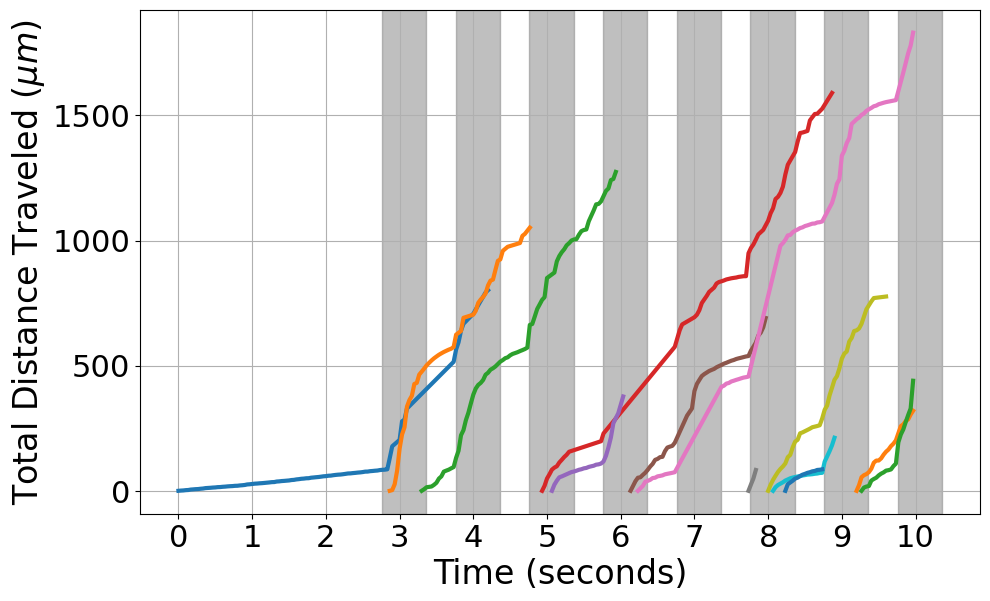

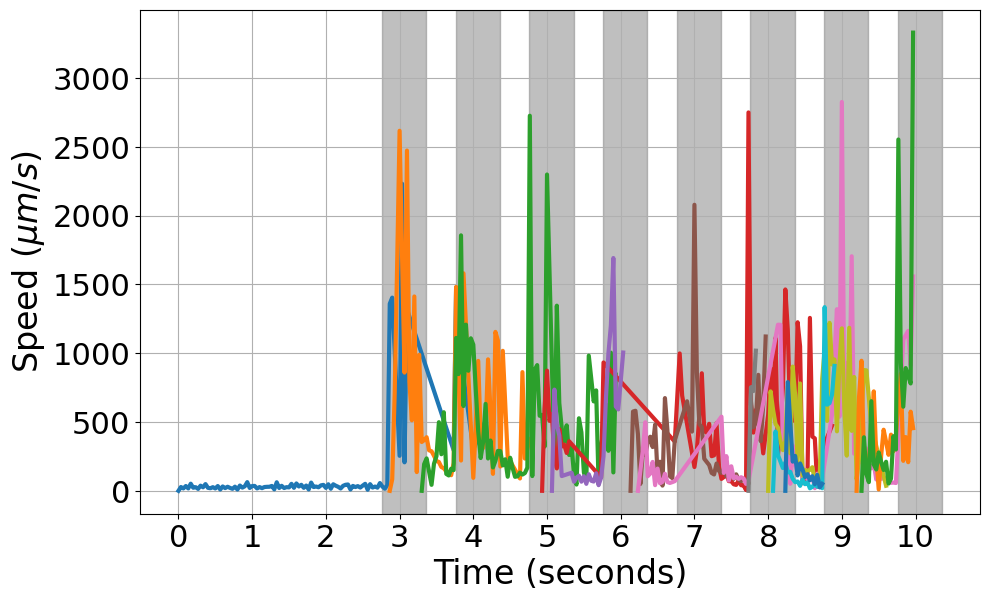

In [85]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
import openpyxl

# Function to create a new XML with specific particles and update the UltrasoundBurstFrame
def create_filtered_xml(xml_file_path, particle_numbers, output_path, hifu_burst_start):
    # Parse the original XML
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Find the <Particles> element
    particles_element = root.find('Particles')

    # Create a new root element
    new_root = ET.Element('ParticleData')

    # Append the updated UltrasoundBurstFrame element to the new root
    new_ultrasound_burst_frame_element = ET.SubElement(new_root, 'UltrasoundBurstFrame')
    new_ultrasound_burst_frame_element.text = str(hifu_burst_start * 30)

    # Create a new <Particles> element
    new_particles_element = ET.Element('Particles')

    # Iterate over each <Particle> element and filter by particle number
    for particle in particles_element.findall('Particle'):
        particle_number = int(particle.find('particle').text)
        if particle_number in particle_numbers:
            new_particles_element.append(particle)

    # Append the new <Particles> element to the new root
    new_root.append(new_particles_element)

    # Write the new tree to a file
    new_tree = ET.ElementTree(new_root)
    new_tree.write(output_path)


# all_peaks_df is already defined
particle_numbers = all_peaks_df['Particle Number'].unique()

# Extract the folder path from the xml_file_path
folder_path = os.path.dirname(xml_file_path)

# Navigate up two levels to the main folder
main_folder = os.path.dirname(os.path.dirname(folder_path))

# Define the name of the new folder to create
folder_name_comp = 'Compilation'

# Create the full path to the new compilation folder
compilation_folder = os.path.join(main_folder, folder_name_comp)

# Check if the compilation folder already exists, and if not, create it
if not os.path.exists(compilation_folder):
    os.makedirs(compilation_folder)

# Create the 'Compiled Plots', 'Compiled xlsx', and 'xml_updated' folders within the compilation folder
plots_folder = os.path.join(compilation_folder, 'Compiled Plots')
xlsx_folder = os.path.join(compilation_folder, 'Compiled xlsx')
xml_updated_folder = os.path.join(compilation_folder, 'xml_updated')

# Check if the folders already exist, and if not, create them
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
if not os.path.exists(xlsx_folder):
    os.makedirs(xlsx_folder)
if not os.path.exists(xml_updated_folder):
    os.makedirs(xml_updated_folder)

# Extract the relevant part of the file name from xml_file_path
file_name_without_ext = os.path.splitext(os.path.basename(xml_file_path))[0]

# Define the full paths for saving the figures with the file name
save_path_fig1 = os.path.join(plots_folder, f'Total_Distance_Traveled_{file_name_without_ext}.png')
save_path_fig2 = os.path.join(plots_folder, f'Speed_{file_name_without_ext}.png')

# Normalize the paths
save_path_fig1 = os.path.normpath(save_path_fig1)
save_path_fig2 = os.path.normpath(save_path_fig2)

# Plot without legends (for saving)
fig1, fig2 = plot_data(filtered_active_traj_filt, hifu_burst_start, max_time=10, with_legend=False)

# Save the plots using the figure objects
fig1.savefig(save_path_fig1, bbox_inches='tight', format='png', dpi=600) # Adjust the dpi as needed, keep as default
fig2.savefig(save_path_fig2, bbox_inches='tight', format='png', dpi=600) # Adjust the dpi as needed

# Define the XLSX file name with the word "metrics"
xlsx_file_name = f"{file_name_without_ext}_additional_metrics.xlsx"

# Define the path for saving the Excel file
save_path_excel = os.path.join(xlsx_folder, xlsx_file_name)
save_path_excel = os.path.normpath(save_path_excel)

# Save all_peaks_df to an Excel file with the sheet name 'Peaks Raw'
with pd.ExcelWriter(save_path_excel, engine='openpyxl') as writer:
    all_peaks_df.to_excel(writer, sheet_name='Peaks Raw', index=False)
    
    # Save velocity_stats to the same Excel file with the sheet name 'Peaks Averaged'
    velocity_stats.to_excel(writer, sheet_name='Peaks Averaged', index=False)

# Load the workbook for the Total Distance Traveled and Speed file
wb_add_metrics = openpyxl.load_workbook(save_path_excel)

# Auto-fit column widths for all sheets in the 'distance_and_speed_metrics' file
for sheet_name in wb_add_metrics.sheetnames:
    ws = wb_add_metrics[sheet_name]
    for col in ws.columns:
        max_length = 0
        column = col[0].column_letter  # Get the column name
        for cell in col:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        ws.column_dimensions[column].width = adjusted_width

# Save the workbook with adjusted column widths
wb_add_metrics.save(save_path_excel)

# Define the XLSX file name for Total Distance Traveled and Speed
distance_speed_file_name = f"{file_name_without_ext}_distance_and_speed_metrics.xlsx"

# Define the path for saving the Total Distance Traveled and Speed file
distance_speed_path_excel = os.path.join(xlsx_folder, distance_speed_file_name)
distance_speed_path_excel = os.path.normpath(distance_speed_path_excel)

# Remove duplicates by keeping the first occurrence
filtered_active_traj_filt = filtered_active_traj_filt.drop_duplicates(subset=['frame', 'particle'])

# Pivot the DataFrame to create separate columns for each particle
total_distance_traveled_df = filtered_active_traj_filt.pivot(index='frame', columns='particle', values='total_distance_traveled')
speed_df = filtered_active_traj_filt.pivot(index='frame', columns='particle', values='speed')

# Rename the column headers to "Particle 1", "Particle 2", etc.
total_distance_traveled_df.columns = [f'Particle {i}' for i in total_distance_traveled_df.columns]
speed_df.columns = [f'Particle {i}' for i in speed_df.columns]

# Save Total Distance Traveled and Speed data to a separate Excel file
with pd.ExcelWriter(distance_speed_path_excel, engine='openpyxl') as writer:
    total_distance_traveled_df.to_excel(writer, sheet_name='Total Distance Traveled (µm)', index_label='Frame')
    speed_df.to_excel(writer, sheet_name='Speed (µm-s)', index_label='Frame')

# Load the workbook for the Total Distance Traveled and Speed file
wb_distance_speed = openpyxl.load_workbook(distance_speed_path_excel)

# Auto-fit column widths for all sheets in the 'distance_and_speed_metrics' file
for sheet_name in wb_distance_speed.sheetnames:
    ws = wb_distance_speed[sheet_name]
    for col in ws.columns:
        max_length = 0
        column = col[0].column_letter  # Get the column name
        for cell in col:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        ws.column_dimensions[column].width = adjusted_width

# Save the workbook with adjusted column widths
wb_distance_speed.save(distance_speed_path_excel)

# Define the output path for the filtered XML
xml_output_path = os.path.join(xml_updated_folder, f"{file_name_without_ext}_filtered.xml")

# Call the function to create the filtered XML
create_filtered_xml(xml_file_path, particle_numbers, xml_output_path, hifu_burst_start)
print(f"Filtered XML file created at: {xml_output_path}")

print(f"Total Distance Traveled and Speed file saved at: {distance_speed_path_excel}")
print(f"Figures saved at: {save_path_fig1} and {save_path_fig2}")
